
# Target/instruments basic use


In normal model use the trajectory of the exogenous variables determine the trajectory of the endogenous (left hand side) variables. However, sometimes  it can be useful to target a trajectory of some endogenous variables by calculating a trajectory of exogenous variables. 

This notebook contains a simple experiment where the level of $CO^2$ emission is targeted by increasing tax on carbon emission, as increased tax will increase government income an unchanged government deficit is also targeted and the government capital expenditure is also an instrument. 

So there are two targets: 
 1. $CO^2$ emission 
 2. Government deficit 
 
And two instruments: 
 1. Carbon emission tax, which is covered by 3 variables 
 2. Government capital expenditure
 
Remember tat the number of targets and the number of instruments should be the same.  
 
The notebook have these main elements:
1. Load a model and data
2. Creating an baseline 
3. Define instrument variables, note that one instrument can consist of several variables. 
4. Define a dataframe with the trajectory of the target variables.  
3. Solve the problem by using the `.invert` method. 
4. Visualizing the results 

This Notebook uses a  model for Pakistan described here: {cite:author}`Burns2021`

In [1]:
%matplotlib inline

## Imports

Modelflow's modelclass includes most of the methods needed to manage a model in Modelflow.

In [2]:
# HIDDEN in jupyterbook 
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2

In [3]:
from modelclass import model 

model.widescreen()
model.scroll_off()

## Load a  model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. The file has been created when onboarding the model. 
Examples can be found [here](../../onboard/eviews/onboard%20one%20model%20from%20%20wf1.html#onboard-a-model-defined-in-a-wf1-file)

In [4]:
mpak,initial = model.modelload('../models/pak.pcim')

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


In [5]:
baseline = mpak(initial,2022,2100,alfa=0.7,silent=1,ljit=False,stringjit=False)
mpak.basedf = baseline.copy()

Compile prolog: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 35.32code chunk/s
Compile core  : 100%|███████████████████████████████████████████████████████████████████████████| 4/4 53.08code chunk/s
Compile epilog: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 58.52code chunk/s



## Target CO2 emission and government deficit by adjusting carbon tax and government expenditure. 

In this experiment the we want **a reduction in CO2 emission in 2100** by increasing the tax on carbon emission. As increased carbon emission tax generates government revenues the government deficit is expected to fall. So we also want **unchanged government deficit** compared to the baseline.  

First step is to create a **target dataframe** which consist of a column for each target and rows for the relevant years. 

### Define target trajectory for CO2 emission. 
In year 2100 we want to reduce the emission **PAKCCEMISCO2TKN** to a percent of the baseline (business as usual)

In [6]:
reduction_percent = 30   # Input the desired reduction in percent. 

The column for emission is created in a couple of steps.

 1. Calculate the target emission in 2100 = $PAKCCEMISCO2TKN_{2100} (1-reduction\_percent/100)$ 
 2. Calculate the yearly growth rate:  $\dfrac{Target_{2100}}{PAKCCEMISCO2TKN_{2022}}^{\frac{1}{2100-2022}}-1$
 3. Calculate target values for emission in each year. 


In pandas speak this is done in the code below. 

In [7]:
bau_2100        = baseline.loc[2100,'PAKCCEMISCO2TKN']
bau_2022        = baseline.loc[2022,'PAKCCEMISCO2TKN']

target_2100 = baseline.loc[2100,'PAKCCEMISCO2TKN']*(1-reduction_percent/100)


target_growth_rate = (target_2100/bau_2022)**(1/(2100-2022))-1
bau_growth_rate = (bau_2100/bau_2022)**(1/(2100-2022))-1

print(f"Business as usual Emission value in 2100: {bau_2100:13,.0f} tons")
print(f"Target  Emission value in 2100          : {target_2100:13,.0f} tons")
print(f"Business as usual growth rate in percent: {bau_growth_rate:13,.1%}")
print(f"Target growth rate in percent           : {target_growth_rate:13,.1%}")

Business as usual Emission value in 2100: 1,950,344,715 tons
Target  Emission value in 2100          : 1,365,241,301 tons
Business as usual growth rate in percent:          2.8%
Target growth rate in percent           :          2.4%


#### Create a dataframe with the target emission 
Now a dataframe can be created using the growth rate for the target variable calculated above. 

The dataframe should only contain columns for the target variables - here only one. 

In [8]:
target_before = baseline.loc[2022:,['PAKCCEMISCO2TKN']]     # Create dataframe with only the target variable 
# create a target dataframe with a projection of the target variable 
target = target_before.upd(f'<2023 2100> PAKCCEMISCO2TKN =growth {100*target_growth_rate}')

### Create target for government deficit 
This is done simply by taking the values in the baseline for the relevant years. 

In [9]:
target.loc[:,'PAKGGBALOVRLCN'] = baseline.loc[2022:2100,'PAKGGBALOVRLCN']

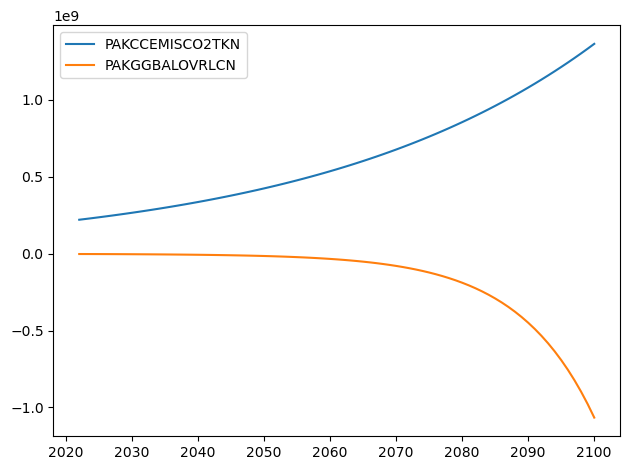

In [10]:
target.plot();

## Define instruments

In [11]:
mpak['PAKGGREVCO2?ER PAKGGEXPCAPTCN_A'].des

PAKGGREVCO2CER   : Carbon tax on coal (USD/t)
PAKGGREVCO2GER   : Carbon tax on gas (USD/t)
PAKGGREVCO2OER   : Carbon tax on oil (USD/t)
PAKGGEXPCAPTCN_A : Add factor:General government expenditure on capital expenditure (millions lcu)


In [12]:
instruments = [['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER'],
               'PAKGGEXPCAPTCN_A']

So the tax instrument consists of 3 variables.  The target consist of 1 variable. 

There is one instrument and one target. Which is a necessary condition for solving the problem. 

### Now solve the problem: 

Now we have a dataframe with target values and a list of instrument variables. We are ready to solve the problem. 

In [13]:
%%time
_ = mpak.invert(baseline,                  # Invert calls the target instrument device                   
                targets = target,                   
                instruments=instruments,
                DefaultImpuls=20,              # The default impulse instrument variables 
                defaultconv=2.0,              # Convergergence criteria for targets
                varimpulse=False,             # Changes in instruments in each iteration are carried over to the future
                nonlin=5,                    # If no convergence in 15 iteration recalculate jacobi 
                silent=1,                     # Don't show iteration output (try 1 for showing)
                delay=0,
               maxiter = 2590)

Finding instruments :   0%|          | 0/79

CPU times: total: 6.5 s
Wall time: 9.42 s


### Make a graph and decorate with a line and an annotation
Also show the tax rate



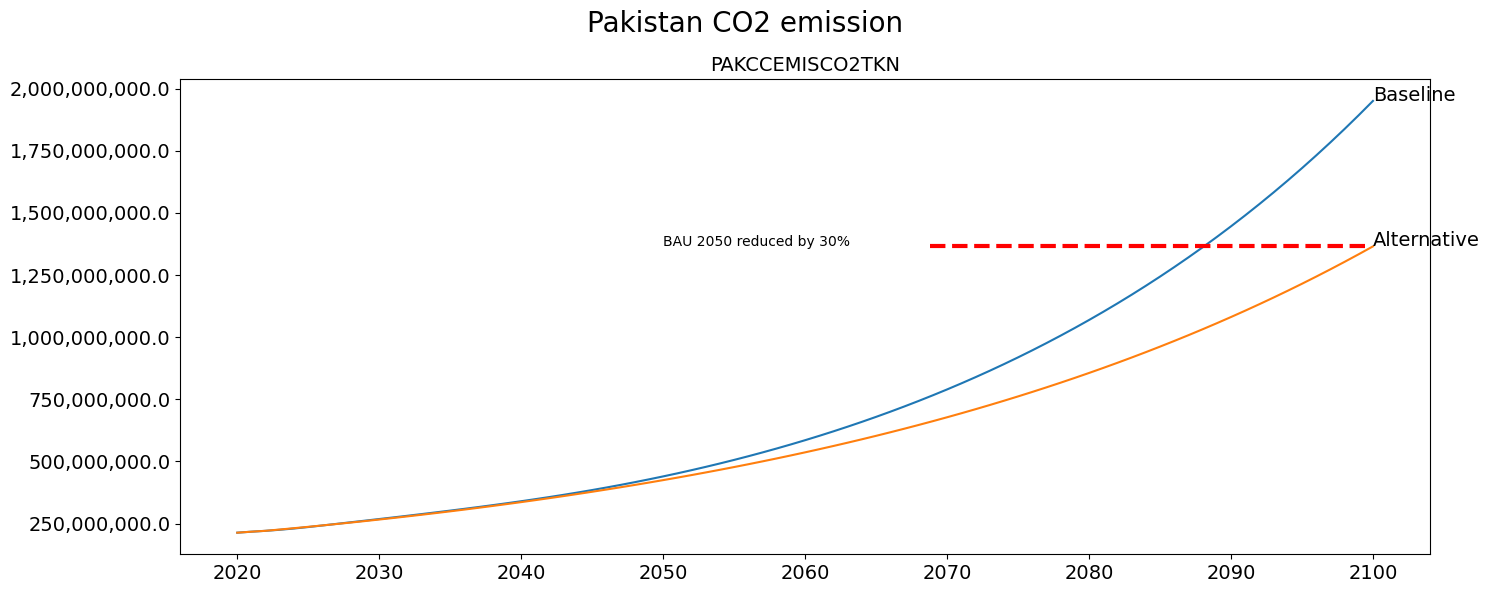

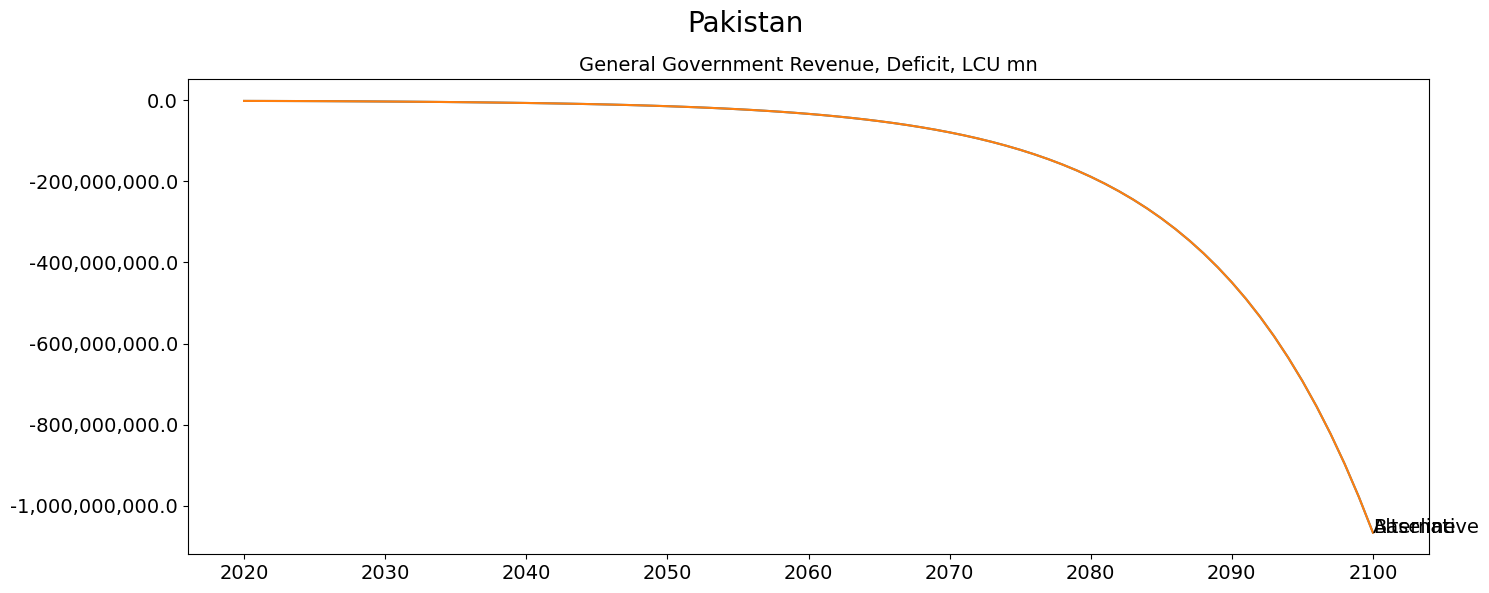

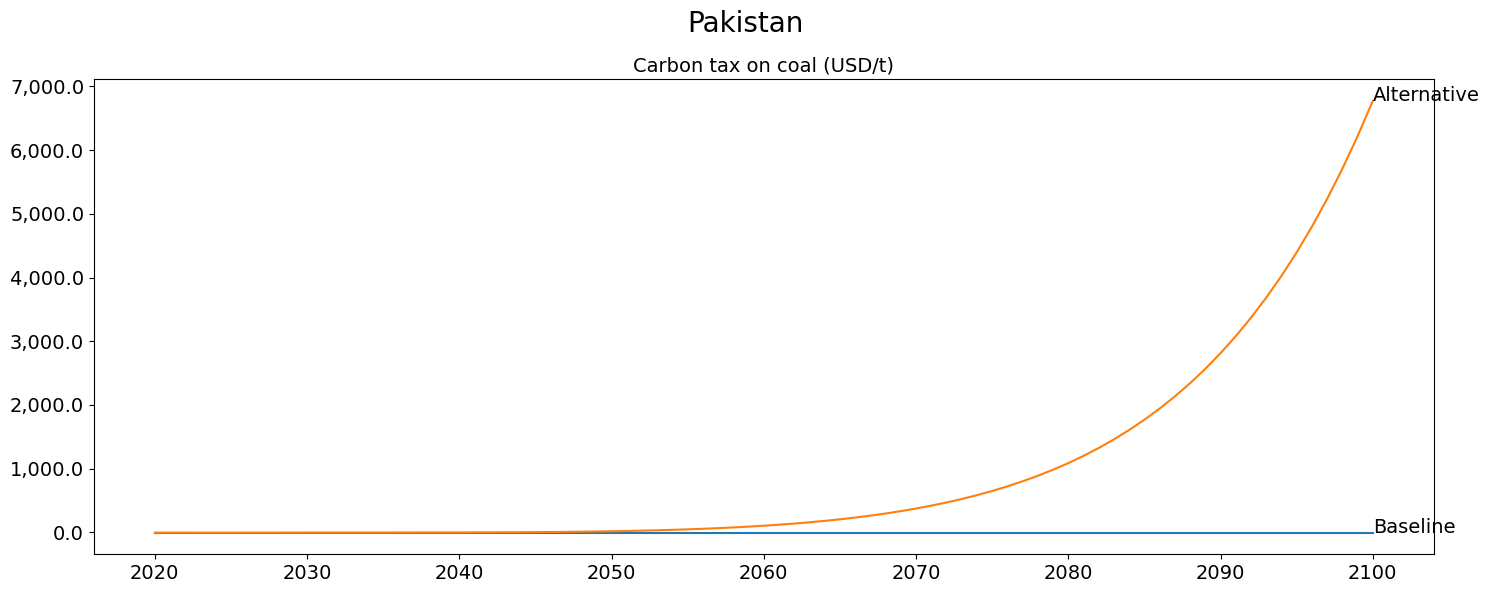

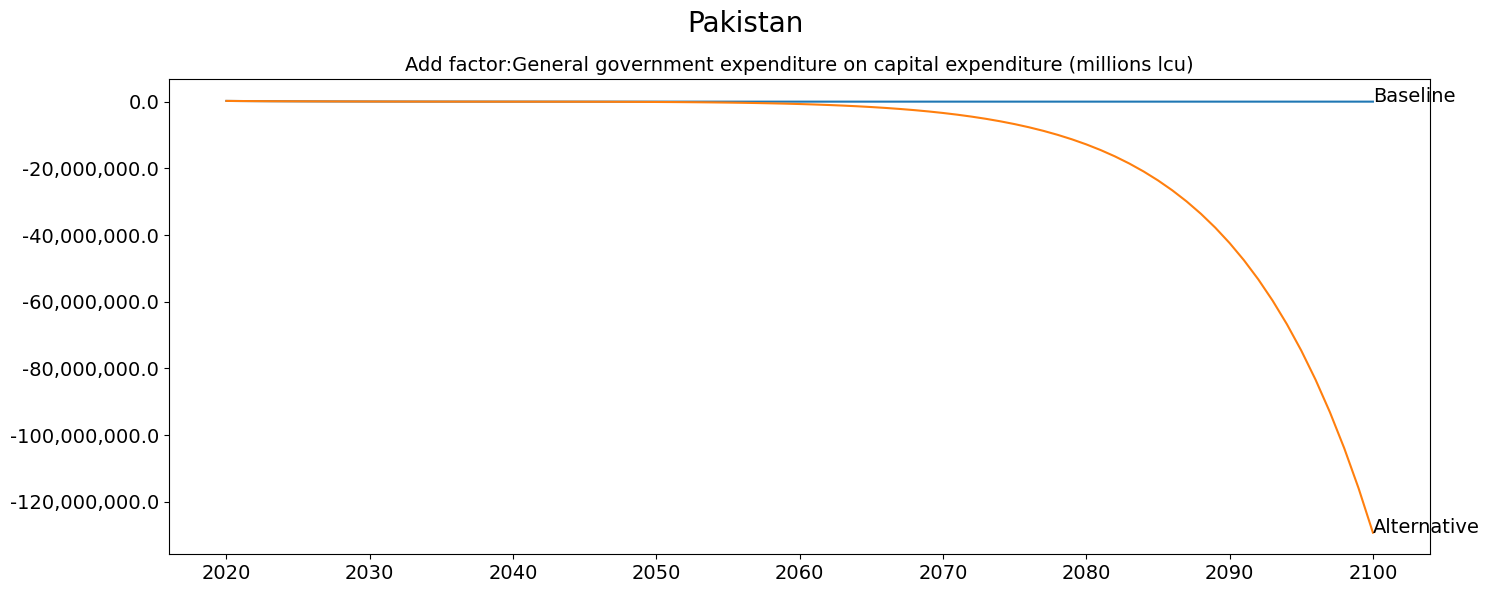

In [14]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan CO2 emission')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.95,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100 ))
    fig0 = mpak[f'PAKGGBALOVRLCN' ].plot_alt(title=f'Pakistan'); 
    fig2 = mpak[f'PAKGGREVCO2CER' ].plot_alt(title=f'Pakistan'); 
    fig3 = mpak[f'PAKGGEXPCAPTCN_A' ].plot_alt(title=f'Pakistan'); 


### Look at selected variables with the [] operator 
If you want to look at multiple variables the index [] operator can be used to select the variables to analyze/visualize. Here only a few operations will be shown. There is more [here](index-operator)

In [15]:
mpak['PAKNYGDPMKTPKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEIMPGNFSKN PAKCCEMISCO2TKN']